In [1]:
import pandas as pd

# Load the datasets
train_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv'
dev_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_dev.tsv'
test_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_test.tsv'

# Load TSV files into DataFrames
train_data = pd.read_csv(train_file_path, sep='\t')
dev_data = pd.read_csv(dev_file_path, sep='\t')
test_data = pd.read_csv(test_file_path, sep='\t')

# Display the first few rows of each dataset
train_data.head(), dev_data.head(), test_data.head()


(             event_name            tweet_id              image_id  \
 0  california_wildfires  917791291823591425  917791291823591425_0   
 1  california_wildfires  917791291823591425  917791291823591425_1   
 2  california_wildfires  917793137925459968  917793137925459968_0   
 3  california_wildfires  917793137925459968  917793137925459968_1   
 4  california_wildfires  917793137925459968  917793137925459968_2   
 
                                           tweet_text  \
 0  RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...   
 1  RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...   
 2  RT @KAKEnews: California wildfires destroy mor...   
 3  RT @KAKEnews: California wildfires destroy mor...   
 4  RT @KAKEnews: California wildfires destroy mor...   
 
                                                image            label  \
 0  data_image/california_wildfires/10_10_2017/917...      informative   
 1  data_image/california_wildfires/10_10_2017/917...  not_informative   
 2  data_ima

In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import CLIPModel, CLIPProcessor
from tqdm.auto import tqdm
import pandas as pd

class ImageAutoencoder(nn.Module):
    """
    Autoencoder using CLIP embeddings as latent representations.
    Compact decoder with rich non-linear blocks.
    """
    def __init__(
        self,
        model_name: str = "openai/clip-vit-base-patch32",
        dropout_prob: float = 0.5,
        freeze_encoder: bool = False
    ):
        super().__init__()
        # Load CLIP image encoder
        self.clip = CLIPModel.from_pretrained(model_name)
        if freeze_encoder:
            for p in self.clip.parameters():
                p.requires_grad = False

        # Projection MLP: latent_dim -> (256*7*7) -> (256*7*7)
        latent_dim = self.clip.config.projection_dim
        hidden = 256 * 7 * 7
        self.project = nn.Sequential(
            nn.Linear(latent_dim, hidden),
            nn.GELU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden, hidden),
            nn.GELU(),
            nn.Dropout(dropout_prob)
        )

        # Helper for conv blocks
        def conv_block(ch):
            return nn.Sequential(
                nn.Conv2d(ch, ch, kernel_size=3, padding=1),
                nn.GELU()
            )

        # Decoder: upsample from 7×7 to 224×224 in 5 stages
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 7→14
            nn.GELU(),
            conv_block(128),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 14→28
            nn.GELU(),
            conv_block(64),

            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # 28→56
            nn.GELU(),
            conv_block(32),

            nn.ConvTranspose2d(32, 16, 4, 2, 1),    # 56→112
            nn.GELU(),
            conv_block(16),

            nn.ConvTranspose2d(16, 3, 4, 2, 1),     # 112→224
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, 3, 224, 224)
        emb = self.clip.get_image_features(pixel_values=x)      # (B, latent_dim)
        feat = self.project(emb).view(-1, 256, 7, 7)            # (B, 256, 7, 7)
        return self.decoder(feat)                               # (B, 3, 224, 224)

class CrisisImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame, processor: CLIPProcessor, img_root: str):
        self.paths = df['image'].tolist()
        self.processor = processor
        self.img_root = img_root

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_root, self.paths[idx])
        image = Image.open(img_path).convert('RGB')
        px = self.processor(images=image, return_tensors='pt').pixel_values.squeeze(0)
        return px, px.clone()

def dice_coefficient(pred: torch.Tensor, target: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    p = pred.view(pred.size(0), -1)
    t = target.view(target.size(0), -1)
    num = 2 * (p * t).sum(1) + eps
    den = p.sum(1) + t.sum(1) + eps
    return (num / den).mean()

def train_autoencoder(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    image_dir: str,
    model_name: str = 'openai/clip-vit-base-patch32',
    batch_size: int = 16,
    lr: float = 1e-4,
    epochs: int = 10,
    freeze_encoder: bool = False,
    device: str = None
) -> ImageAutoencoder:
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    processor = CLIPProcessor.from_pretrained(model_name)

    train_loader = DataLoader(
        CrisisImageDataset(train_df, processor, image_dir),
        batch_size=batch_size,
        shuffle=True
    )
    val_loader = DataLoader(
        CrisisImageDataset(val_df, processor, image_dir),
        batch_size=batch_size
    )

    model = ImageAutoencoder(model_name, dropout_prob=0.5, freeze_encoder=freeze_encoder).to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(1, epochs + 1):
        model.train()
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            optimizer.step()

        model.eval()
        val_losses, val_dices = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                preds = model(x)
                val_losses.append(loss_fn(preds, y).item())
                val_dices.append(dice_coefficient(preds, y).item())
        print(f"Epoch {epoch}: Val Loss {sum(val_losses)/len(val_losses):.4f}, "
              f"Val Dice {sum(val_dices)/len(val_dices):.4f}")

    return model

if __name__ == '__main__':
    # Load your data splits
    train_df = pd.read_csv(
        'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv',
        sep='\t'
    )
    val_df = pd.read_csv(
        'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_dev.tsv',
        sep='\t'
    )

    # Train the full autoencoder
    model = train_autoencoder(train_df, val_df, image_dir='')

    # ---- Save decoder only ----
    save_dir = r"D:/BTP/CrisisMMD_v2.0/model/Model_CLIP_Decoder_endtoend"
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, "decoder_only.pth")
    torch.save(model.decoder.state_dict(), save_path)
    print(f"Decoder weights saved to {save_path}")




c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epoch 1/10:  49%|████▉     | 419/851 [03:45<03:14,  2.22it/s]c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/10: 100%|██████████| 851/851 [07:02<00:00,  2.01it/s]


Epoch 1: Val Loss 1.0040, Val Dice 0.7187


Epoch 2/10: 100%|██████████| 851/851 [06:19<00:00,  2.24it/s]


Epoch 2: Val Loss 1.0734, Val Dice 0.1506


Epoch 3/10: 100%|██████████| 851/851 [06:17<00:00,  2.26it/s]


Epoch 3: Val Loss 0.9975, Val Dice 0.3550


Epoch 4/10: 100%|██████████| 851/851 [06:17<00:00,  2.26it/s]


Epoch 4: Val Loss 0.9910, Val Dice 0.3839


Epoch 5/10: 100%|██████████| 851/851 [06:18<00:00,  2.25it/s]


Epoch 5: Val Loss 1.0126, Val Dice 0.4078


Epoch 6/10: 100%|██████████| 851/851 [06:17<00:00,  2.26it/s]


Epoch 6: Val Loss 0.9706, Val Dice 0.0507


Epoch 7/10: 100%|██████████| 851/851 [06:17<00:00,  2.26it/s]


Epoch 7: Val Loss 0.9715, Val Dice 0.3083


Epoch 8/10: 100%|██████████| 851/851 [06:17<00:00,  2.26it/s]


Epoch 8: Val Loss 0.9689, Val Dice 0.7548


Epoch 9/10: 100%|██████████| 851/851 [06:16<00:00,  2.26it/s]


Epoch 9: Val Loss 0.9658, Val Dice 1.6874


Epoch 10/10: 100%|██████████| 851/851 [06:17<00:00,  2.26it/s]


Epoch 10: Val Loss 0.9654, Val Dice 2.4776
Decoder weights saved to D:/BTP/CrisisMMD_v2.0/model/Model_CLIP_Decoder_endtoend\decoder_only.pth


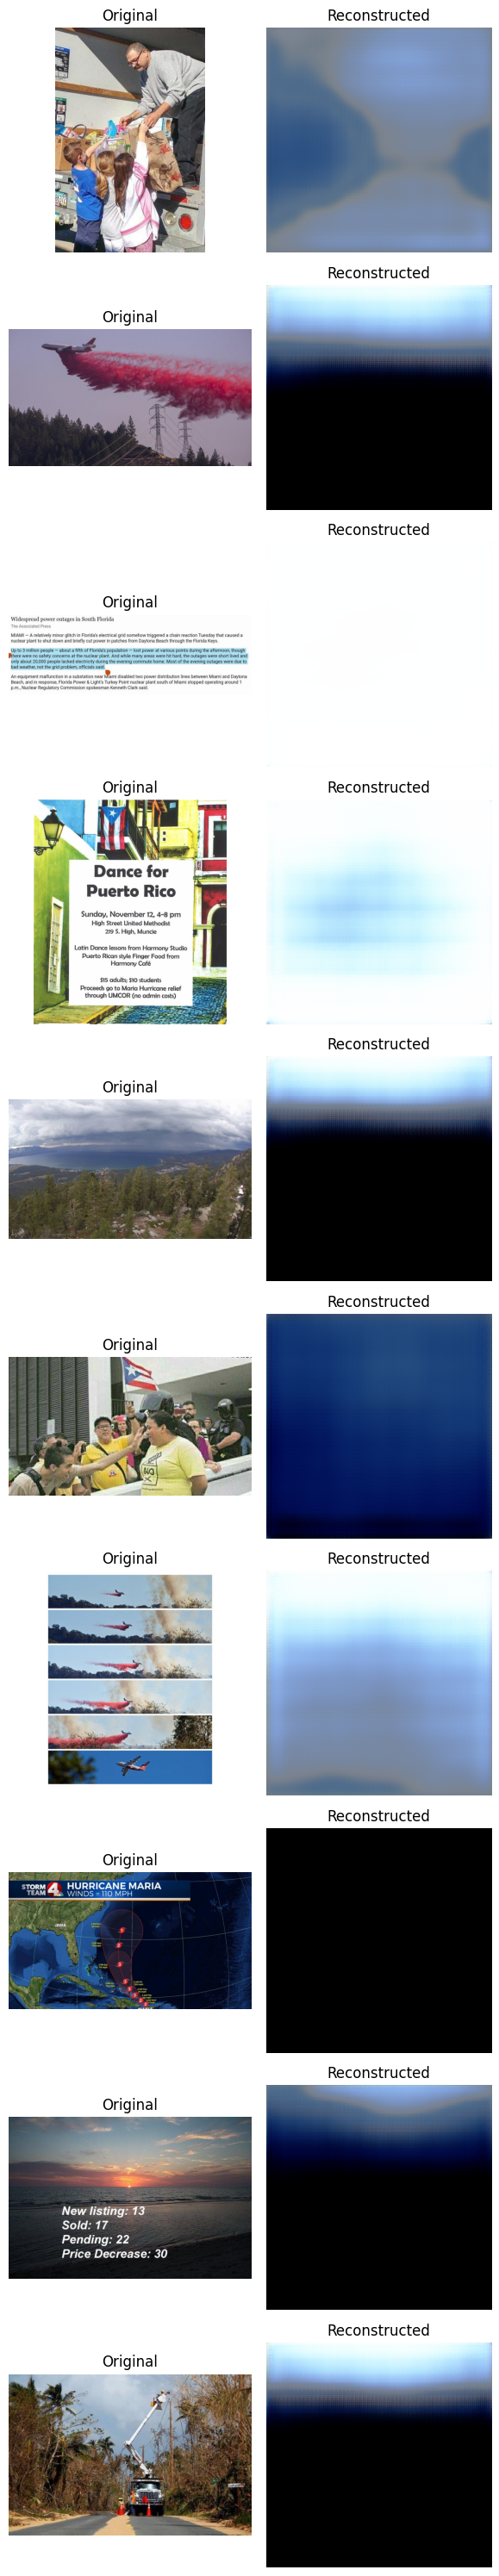

In [5]:
import pandas as pd
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import CLIPProcessor
from torchvision import transforms

def reconstruct_test_examples(model, test_df, image_dir, processor, num_examples=10, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    model.to(device)
    
    sample_df = test_df.sample(n=num_examples, random_state=42).reset_index(drop=True)
    
    fig, axs = plt.subplots(num_examples, 2, figsize=(6, num_examples * 3))
    if num_examples == 1:  # handle single example edge case
        axs = [axs]

    for i in range(num_examples):
        image_path = os.path.join(image_dir, sample_df.loc[i, "image"])
        image = Image.open(image_path).convert("RGB")
        
        # Preprocess image
        inputs = processor(images=image, return_tensors="pt")
        pixel_values = inputs["pixel_values"].to(device)

        with torch.no_grad():
            reconstructed = model(pixel_values)

        reconstructed_img = reconstructed.squeeze().cpu().permute(1, 2, 0).numpy()
        reconstructed_img = (reconstructed_img * 255).clip(0, 255).astype("uint8")

        # Show original
        axs[i][0].imshow(image)
        axs[i][0].set_title("Original")
        axs[i][0].axis("off")

        # Show reconstructed
        axs[i][1].imshow(reconstructed_img)
        axs[i][1].set_title("Reconstructed")
        axs[i][1].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
test_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_test.tsv'
image_dir = ''

test_df = pd.read_csv(test_file_path, sep='\t')
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Call after training
reconstruct_test_examples(model, test_df, image_dir, processor, num_examples=10)


In [4]:
import os
import torch

# assume `model` is your trained ImageAutoencoder instance

# target directory
save_dir = r'D:/BTP/CrisisMMD_v2.0/model/Model_CLIP_Decoder_endtoend'
os.makedirs(save_dir, exist_ok=True)

# extract and save decoder weights only
decoder_state = model.decoder.state_dict()
torch.save(decoder_state, os.path.join(save_dir, 'decoder_only.pth'))

print(f"Decoder weights saved to {os.path.join(save_dir, 'decoder_only.pth')}")


Decoder weights saved to D:/BTP/CrisisMMD_v2.0/model/Model_CLIP_Decoder_endtoend\decoder_only.pth
